# Compare Batch Resetting Schedules


In [1]:
import numpy as np
from utils import print_dict_summary, print_first, str2time, logging_setup
import pickle
import logging
import os.path as osp
from moisture_rnn_pkl import pkl2train
from moisture_rnn import RNNParams, RNNData, RNN 
from utils import hash2, read_yml, read_pkl, retrieve_url
from moisture_rnn import RNN
import reproducibility
from data_funcs import rmse, to_json, combine_nested, process_train_dict
from moisture_models import run_augmented_kf
import copy
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import time
import reproducibility
import tensorflow as tf

In [2]:
logging_setup()

In [3]:
retrieve_url(
    url = "https://demo.openwfm.org/web/data/fmda/dicts/test_CA_202401.pkl", 
    dest_path = "fmda_nw_202401-05_f05.pkl")

Target data already exists at fmda_nw_202401-05_f05.pkl


In [4]:
repro_file = "data/reproducibility_dict_v2_TEST.pkl"
file_names=['fmda_nw_202401-05_f05.pkl']
file_dir='data'
file_paths = [osp.join(file_dir,file_name) for file_name in file_names]

In [5]:
params_all = read_yml("params.yaml")
params_data = read_yml("params_data.yaml")

In [6]:
data_params = read_yml("params_data.yaml")
data_params.update({
    'hours': 1440,
    'max_intp_time': 24,
    'zero_lag_threshold': 24
})
train = process_train_dict(["data/fmda_nw_202401-05_f05.pkl"], params_data=params_data, verbose=True)

2024-09-25 14:48:27,186 - INFO - PLFI1_202401 HRRR.time time array increments are 1.0 hours
2024-09-25 14:48:27,328 - INFO - PLFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-09-25 14:48:27,468 - INFO - SADI1_202401 HRRR.time time array increments are 1.0 hours
2024-09-25 14:48:27,628 - INFO - SADI1_202401 RAWS.time_raws time array increments are min 1.0 max 3.0
2024-09-25 14:48:27,762 - INFO - SRFI1_202401 HRRR.time time array increments are 1.0 hours
2024-09-25 14:48:27,865 - INFO - SRFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-09-25 14:48:28,032 - INFO - WEFI1_202401 HRRR.time time array increments are 1.0 hours
2024-09-25 14:48:28,176 - INFO - WEFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-09-25 14:48:28,310 - INFO - AGFO3_202401 HRRR.time time array increments are 1.0 hours
2024-09-25 14:48:28,462 - INFO - AGFO3_202401 RAWS.time_raws time array increments are min 1.0 max 4.0
2024-09-25 14:48:28,625 -

In [7]:
from itertools import islice
train = {k: train[k] for k in islice(train, 250)}

In [8]:
params = RNNParams(read_yml("params.yaml", subkey="rnn"))
params.update({'epochs': 200, 
               'learning_rate': 0.001,
               'activation': ['tanh', 'tanh'], # Activation for RNN Layers, Dense layers respectively.
               'recurrent_layers': 1, 'recurrent_units': 30, 
               'dense_layers': 1, 'dense_units': 30,
               'early_stopping_patience': 30, # how many epochs of no validation accuracy gain to wait before stopping
               'batch_schedule_type': 'exp', # Hidden state batch reset schedule
               'bmin': 20, # Lower bound of hidden state batch reset, 
               'bmax': params_data['hours'], # Upper bound of hidden state batch reset, using max hours
               'features_list': ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind'],
               'timesteps': 5
              })

Checking params...
Input dictionary passed all checks.
Calculating shape params based on features list, timesteps, and batch size
Input Feature List: ['Ed', 'Ew', 'rain']
Input Timesteps: 12
Input Batch Size: 32
Calculated params:
Number of features: 3
Batch Shape: (32, 12, 3)
{'batch_size': 32, 'timesteps': 12, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['relu', 'relu'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 200, 'epochs': 20, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 5, 'predict_spinup_hours': 5, 'n_features': 3, 'batch_shape': (32, 12, 3)}
Calculating shape params based on features list, timesteps, and batch size
In

## Handle Data

In [9]:
train_sp = combine_nested(train)
rnn_dat = RNNData(
    train_sp, # input dictionary
    scaler="standard",  # data scaling type
    features_list = params['features_list'] # features for predicting outcome
)


rnn_dat.train_test_split(   
    time_fracs = [.8, .1, .1], # Percent of total time steps used for train/val/test
    space_fracs = [.8, .1, .1] # Percent of total timeseries used for train/val/test
)
rnn_dat.scale_data()

rnn_dat.batch_reshape(
    timesteps = params['timesteps'], # Timesteps aka sequence length for RNN input data. 
    batch_size = params['batch_size'], # Number of samples of length timesteps for a single round of grad. descent
    # start_times = np.zeros(len(rnn_dat.loc['train_locs']))
)

params.update({
    'loc_batch_reset': rnn_dat.n_seqs # Used to reset hidden state when location changes for a given batch
})

Input data from multiple timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
Subsetting locations into train/val/test
Total Locations: 250
Train Locations: 200
Val. Locations: 25
Test Locations: 25
X_train[0] shape: (576, 8), y_train[0] shape: (576, 1)
X_val[0] shape: (72, 8), y_val[0] shape: (72, 1)
X_test[0] shape: (72, 8), y_test[0] shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping spatial training data using batch size: 32 and timesteps: 5
Setting total hours to minimum length of y in provided dictionary
Setting Start times to offset by 1 hour by location
Reshaping validation data using batch size: 32 and timesteps: 5
Setting total hours to minimum length of y in provided dictionary
Setting Start times to offset by 1 hour by location
Reshaping test data by stacking. Output di

## Non-Stateful

In [10]:
params.update({
    'stateful': False,
    'batch_schedule_type': None
})

resetting random seeds to 123
Initial Weights Hash: d2ea6505897840e6d790aebcdd00784f
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': None, 'bmin': 20, 'bmax': 720, 'epochs': 200, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': False, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 30, 'predict_spinup_hours': 5, 'n_features': 8, 'batch_shape': (32, 5, 8), 'recurrent_layers': 1, 'recurrent_units': 30, 'loc_batch_reset': 75}
Using ResetStatesCallback with Batch Reset Schedule: None
Using early stopping callback.
Formatted X_train hash: 12bc78b5f8c1670

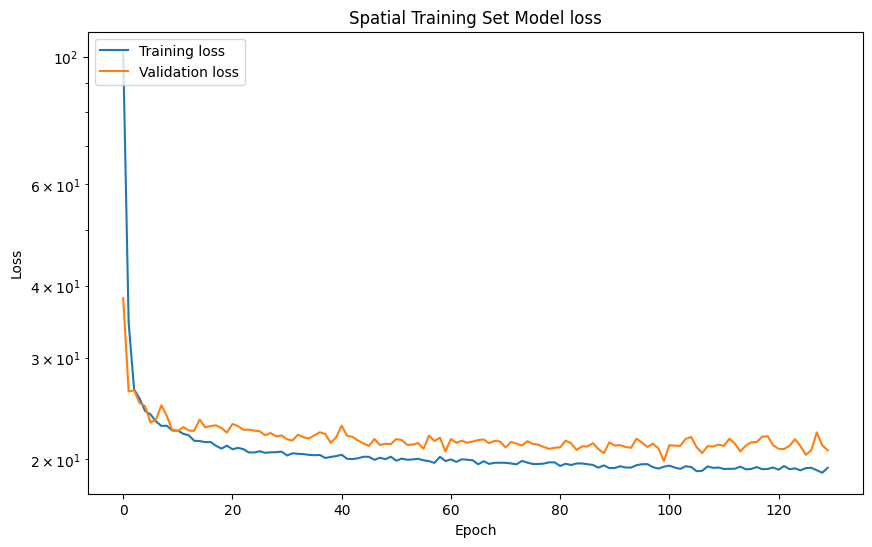

Fitted Weights Hash: 9b8c0925e9efad5a31b4f07ba5c798e6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


In [11]:
reproducibility.set_seed(123)
rnn = RNN(params)
m0, errs0, epochs0 = rnn.run_model(rnn_dat, return_epochs=True)

In [12]:
errs0.mean()

5.37795843909477

In [13]:
for layer in rnn.model_train.layers:
    if isinstance(layer, tf.keras.layers.RNN) and layer.stateful: 
        print(f"Layer {layer} is stateful")

## Stateful, No Batch Schedule

In [14]:
params.update({
    'stateful': True, 
    'batch_schedule_type':None})

resetting random seeds to 123
Initial Weights Hash: d2ea6505897840e6d790aebcdd00784f
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': None, 'bmin': 20, 'bmax': 720, 'epochs': 200, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 30, 'predict_spinup_hours': 5, 'n_features': 8, 'batch_shape': (32, 5, 8), 'recurrent_layers': 1, 'recurrent_units': 30, 'loc_batch_reset': 75}
Using ResetStatesCallback with Batch Reset Schedule: None
Using early stopping callback.
Formatted X_train hash: 12bc78b5f8c16701

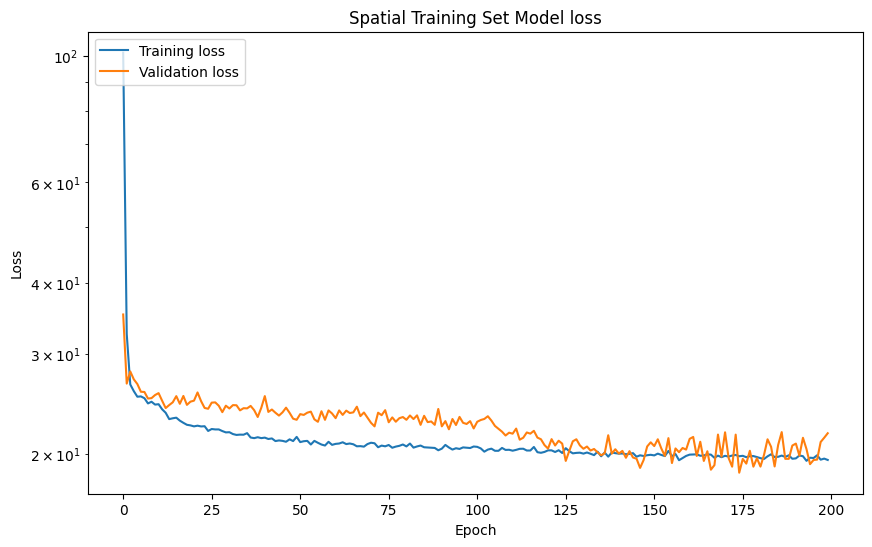

Fitted Weights Hash: ae77d4dbd16746fc1829ce4c940b7ef0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


In [15]:
reproducibility.set_seed(123)
rnn = RNN(params)
m1, errs1, epochs1 = rnn.run_model(rnn_dat, return_epochs=True)

In [16]:
errs1.mean()

4.125001930312955

## Constant Batch Schedule (Stateful)

In [17]:
params.update({
    'stateful': True, 
    'batch_schedule_type':'constant', 
    'bmin': 20})

resetting random seeds to 123
Initial Weights Hash: d2ea6505897840e6d790aebcdd00784f
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'constant', 'bmin': 20, 'bmax': 720, 'epochs': 200, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 30, 'predict_spinup_hours': 5, 'n_features': 8, 'batch_shape': (32, 5, 8), 'recurrent_layers': 1, 'recurrent_units': 30, 'loc_batch_reset': 75}
Using ResetStatesCallback with Batch Reset Schedule: constant
batch_reset_intervals: [20 20 20 20 20 20 20 20 20 20 20 20 2

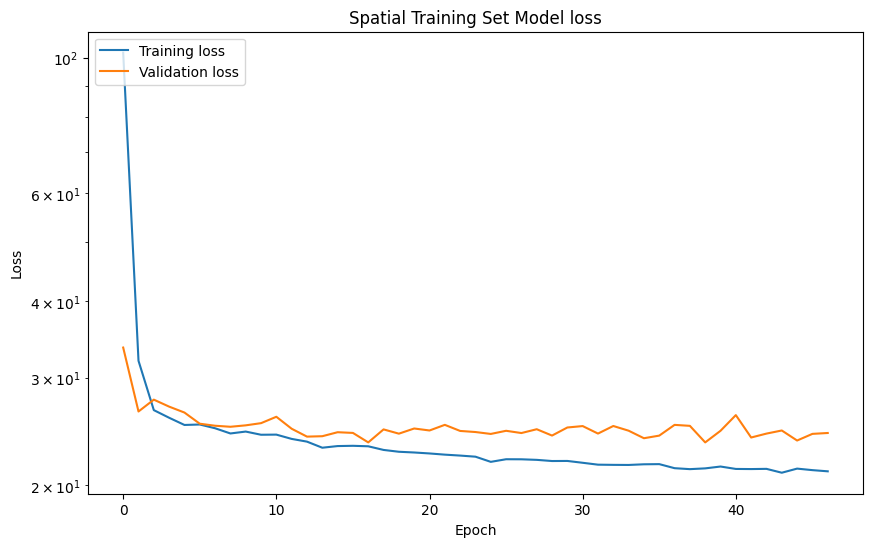

Fitted Weights Hash: 186e9427aef1806c2312673bf56dd8ef
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [18]:
reproducibility.set_seed(123)
rnn = RNN(params)
m2, errs2, epochs2 = rnn.run_model(rnn_dat, return_epochs=True)

In [19]:
errs2.mean()

4.231119714853756

## Exp Batch Schedule (Stateful)

In [20]:
params.update({
    'stateful': True, 
    'batch_schedule_type':'exp', 
    'bmin': 20,
    'bmax': rnn_dat.hours
})

resetting random seeds to 123
Initial Weights Hash: d2ea6505897840e6d790aebcdd00784f
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 720, 'epochs': 200, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 30, 'predict_spinup_hours': 5, 'n_features': 8, 'batch_shape': (32, 5, 8), 'recurrent_layers': 1, 'recurrent_units': 30, 'loc_batch_reset': 75}
Using ResetStatesCallback with Batch Reset Schedule: exp
batch_reset_intervals: [ 20  20  20  21  21  21  22  22  23  23  23  24

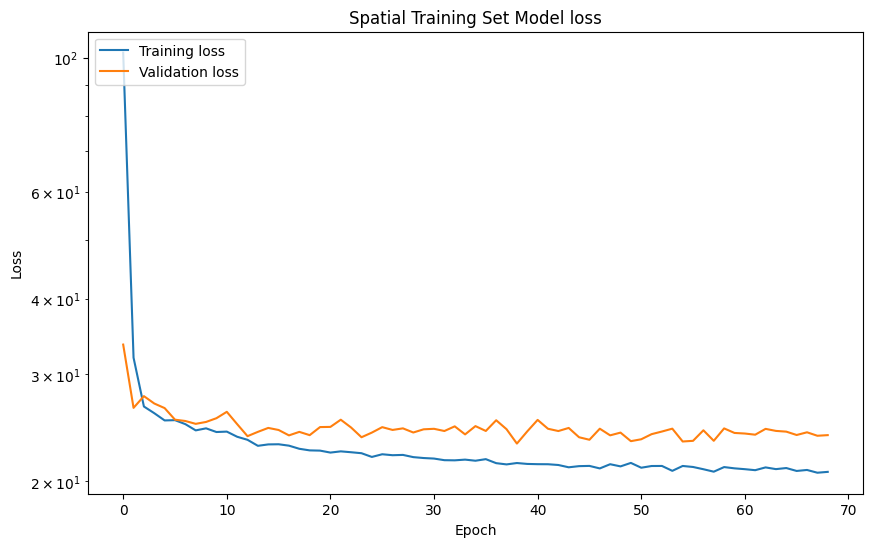

Fitted Weights Hash: 257298fa6c846abc6916211ad728cc86
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [21]:
reproducibility.set_seed(123)
rnn = RNN(params)
m3, errs3, epochs3 = rnn.run_model(rnn_dat, return_epochs=True)

In [22]:
errs3.mean()

4.1284413738559405

In [23]:
for layer in rnn.model_train.layers:
    if isinstance(layer, tf.keras.layers.RNN) and layer.stateful: 
        print(f"Layer {layer} is stateful")

Layer <SimpleRNN name=simple_rnn_6, built=True> is stateful
